# AI CA5-p2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! cp "/content/drive/MyDrive/Colab Notebooks/AI-data/UTKface_Aligned&cropped/UTKFace.tar.gz" .

In [ ]:
!tar xvzf UTKFace.tar.gz

In [5]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorboard
import os
from tensorflow.keras import *
from tensorflow.keras.utils import *
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import math
import tensorflow as tf

In [51]:
img_path = []
races = []
path = "/content/UTKFace"
for img in os.listdir(path):
  temp = img.split('.')
  if len(temp[0].split('_')) == 4:
    img_path.append(os.path.join(path, img))
    age, gender, race, date = temp[0].split('_')
    races.append(int(race))

Below we make the data a onehot vector and the reason for this is that the calsses are categorical and we need to enumerate them. one of the ways it to just give a number to any class but this will result in having ordering of datas meaning if we are between asian and white we will get black whitch is not the case. another way of handling categorical data is one hot vector witch gives every out put a feature and the answer has the feature as the highest value. also our neural network model works with one hot vector for classification

In [52]:
ClassLabels = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
races = [str(to_categorical(i, len(ClassLabels))[::-1]) for i in races]
df = pd.DataFrame({'Image': img_path, 'Race' : races})

In [53]:
dataGenerator = preprocessing.image.ImageDataGenerator(rescale=1.0/255, validation_split=.3)
X_train = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = "Image",
    y_col = "Race",
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'training',
    shuffle = False
)

Found 16594 validated image filenames belonging to 5 classes.


In [54]:
X_test = dataGenerator.flow_from_dataframe(
    dataframe = df,
    x_col = "Image",
    y_col = "Race",
    target_size = (100, 100),
    color_mode = "grayscale",
    batch_size = 32,
    class_mode = 'categorical',
    subset = 'validation',
    shuffle = False
)

Found 7111 validated image filenames belonging to 5 classes.


# 3: 
## P0: SGD without momentum

In [124]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

In [125]:
model = models.Model(inputs = input, outputs = output)

In [126]:
model.compile(optimizer=optimizers.SGD(learning_rate=.01), loss="categorical_crossentropy", metrics=["accuracy"])

In [127]:
log = model.fit(X_train, validation_data=X_test, epochs=10)

Epoch 1/10
519/519 [==============================] - 48s 92ms/step - loss: 1.2871 - accuracy: 0.4943 - val_loss: 1.1437 - val_accuracy: 0.5427
Epoch 2/10
519/519 [==============================] - 47s 91ms/step - loss: 1.1205 - accuracy: 0.5818 - val_loss: 1.1319 - val_accuracy: 0.5470
Epoch 3/10
519/519 [==============================] - 47s 91ms/step - loss: 1.0406 - accuracy: 0.6143 - val_loss: 0.9875 - val_accuracy: 0.6451
Epoch 4/10
519/519 [==============================] - 47s 91ms/step - loss: 0.9820 - accuracy: 0.6397 - val_loss: 1.0074 - val_accuracy: 0.6238
Epoch 5/10
519/519 [==============================] - 47s 91ms/step - loss: 0.9510 - accuracy: 0.6561 - val_loss: 0.9358 - val_accuracy: 0.6562
Epoch 6/10
519/519 [==============================] - 47s 91ms/step - loss: 0.9193 - accuracy: 0.6697 - val_loss: 0.9333 - val_accuracy: 0.6542
Epoch 7/10
519/519 [==============================] - 47s 91ms/step - loss: 0.8921 - accuracy: 0.6789 - val_loss: 0.8948 - val_accuracy:

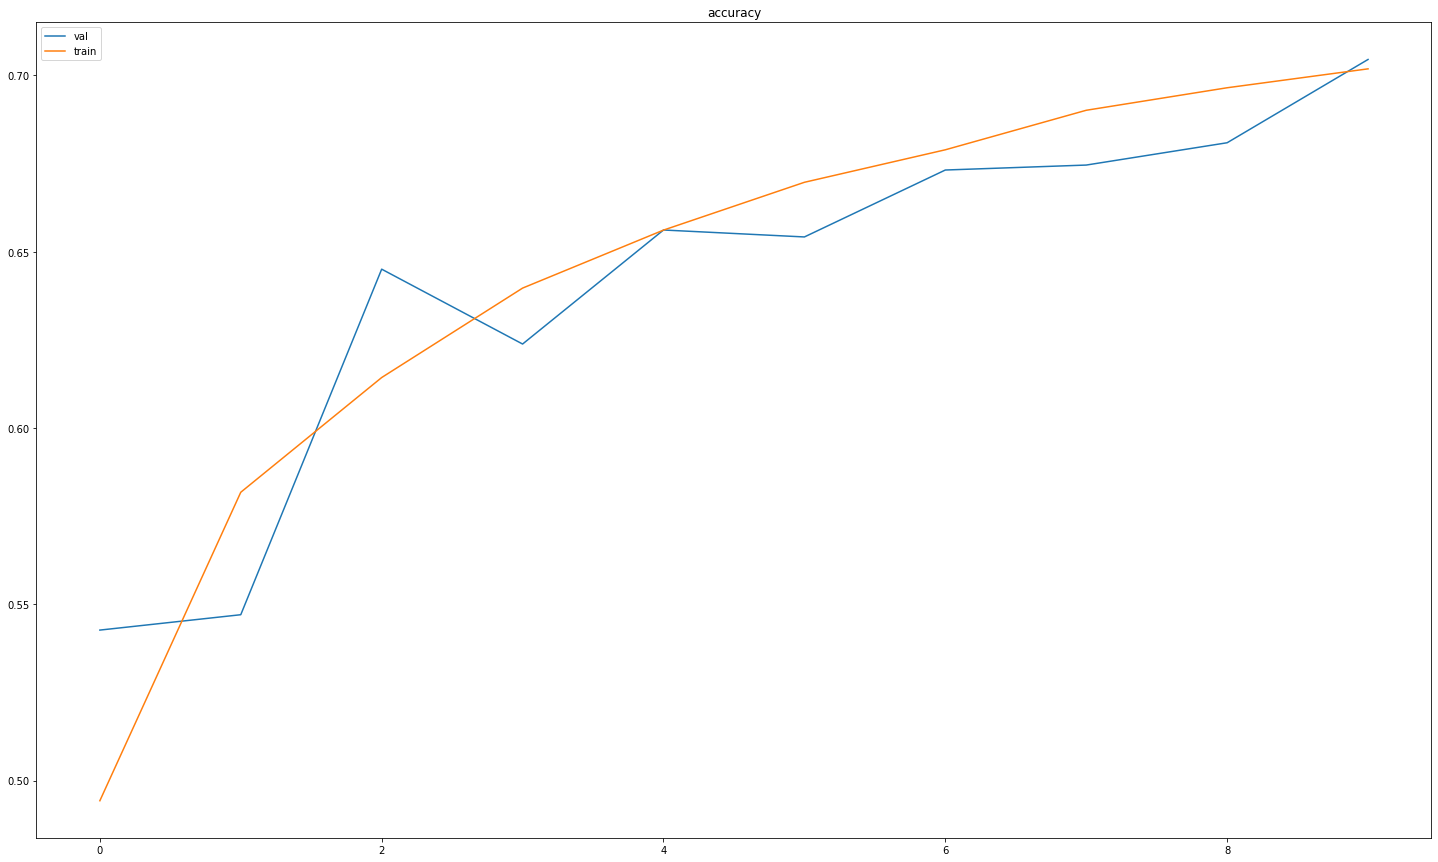

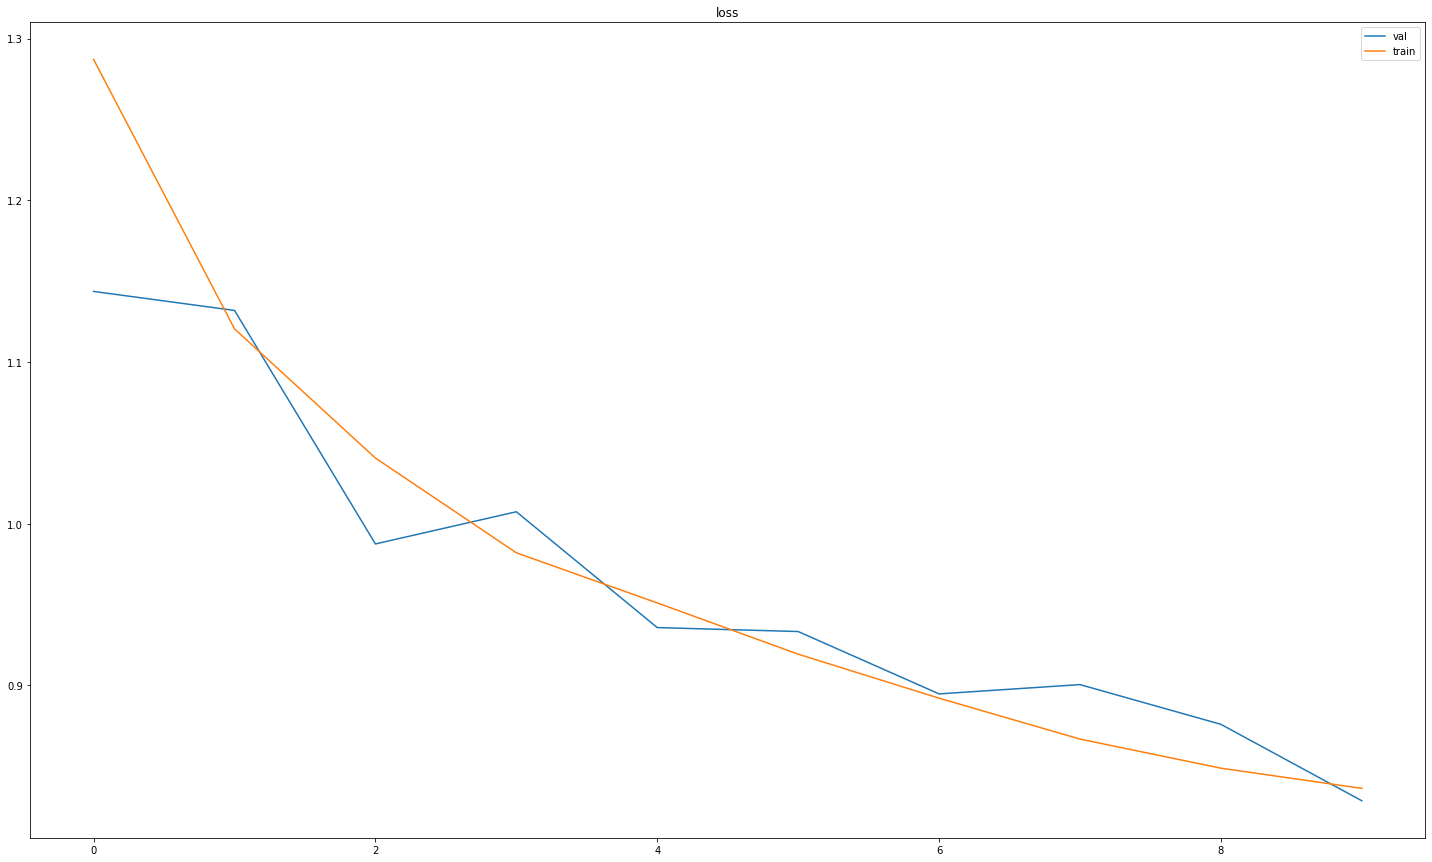

In [128]:
plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

In [129]:
y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)

In [130]:
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

              precision    recall  f1-score   support

       White       0.33      0.03      0.05       553
       Black       0.55      0.69      0.61      1165
       Asian       0.75      0.65      0.70      1064
      Indian       0.82      0.74      0.78      1334
      Others       0.72      0.84      0.78      2995

    accuracy                           0.70      7111
   macro avg       0.63      0.59      0.58      7111
weighted avg       0.69      0.70      0.68      7111



In [131]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_16 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_17 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 1285      
Total params: 10,898,437
Trainable params: 10,898,437
Non-trainable params: 0
_______________________________________________

## P1
#### What is momentum and why use it
think of learning as walking on a hill on which we want to find the tallest hill. In SGD we always walk in the direction thats makes it max and we don't care what was the last step. Doing this will result in getting stuck in local maximums if the plain has a lot of local maximums. <br>
The momentum idea gives our freewalker a momentum meaning we rather walk keep walking in the direction we were already walking. this helps us escape local maximums. and get better results.<br>
having a very small momentum is like having no momentum and the problems I explained. Having a very larg momentum might make us miss the maximum we want to reach and result a worst accuracy.

Epoch 1/10
519/519 [==============================] - 51s 98ms/step - loss: 1.2545 - accuracy: 0.5132 - val_loss: 1.0821 - val_accuracy: 0.5950
Epoch 2/10
519/519 [==============================] - 51s 98ms/step - loss: 1.0552 - accuracy: 0.6075 - val_loss: 0.9616 - val_accuracy: 0.6420
Epoch 3/10
519/519 [==============================] - 51s 98ms/step - loss: 0.9892 - accuracy: 0.6398 - val_loss: 1.0866 - val_accuracy: 0.5743
Epoch 4/10
519/519 [==============================] - 51s 97ms/step - loss: 0.9344 - accuracy: 0.6608 - val_loss: 0.9394 - val_accuracy: 0.6501
Epoch 5/10
519/519 [==============================] - 51s 97ms/step - loss: 0.9021 - accuracy: 0.6787 - val_loss: 1.0260 - val_accuracy: 0.6330
Epoch 6/10
519/519 [==============================] - 51s 98ms/step - loss: 0.8759 - accuracy: 0.6860 - val_loss: 0.9578 - val_accuracy: 0.6536
Epoch 7/10
519/519 [==============================] - 51s 99ms/step - loss: 0.8550 - accuracy: 0.6955 - val_loss: 1.0064 - val_accuracy:

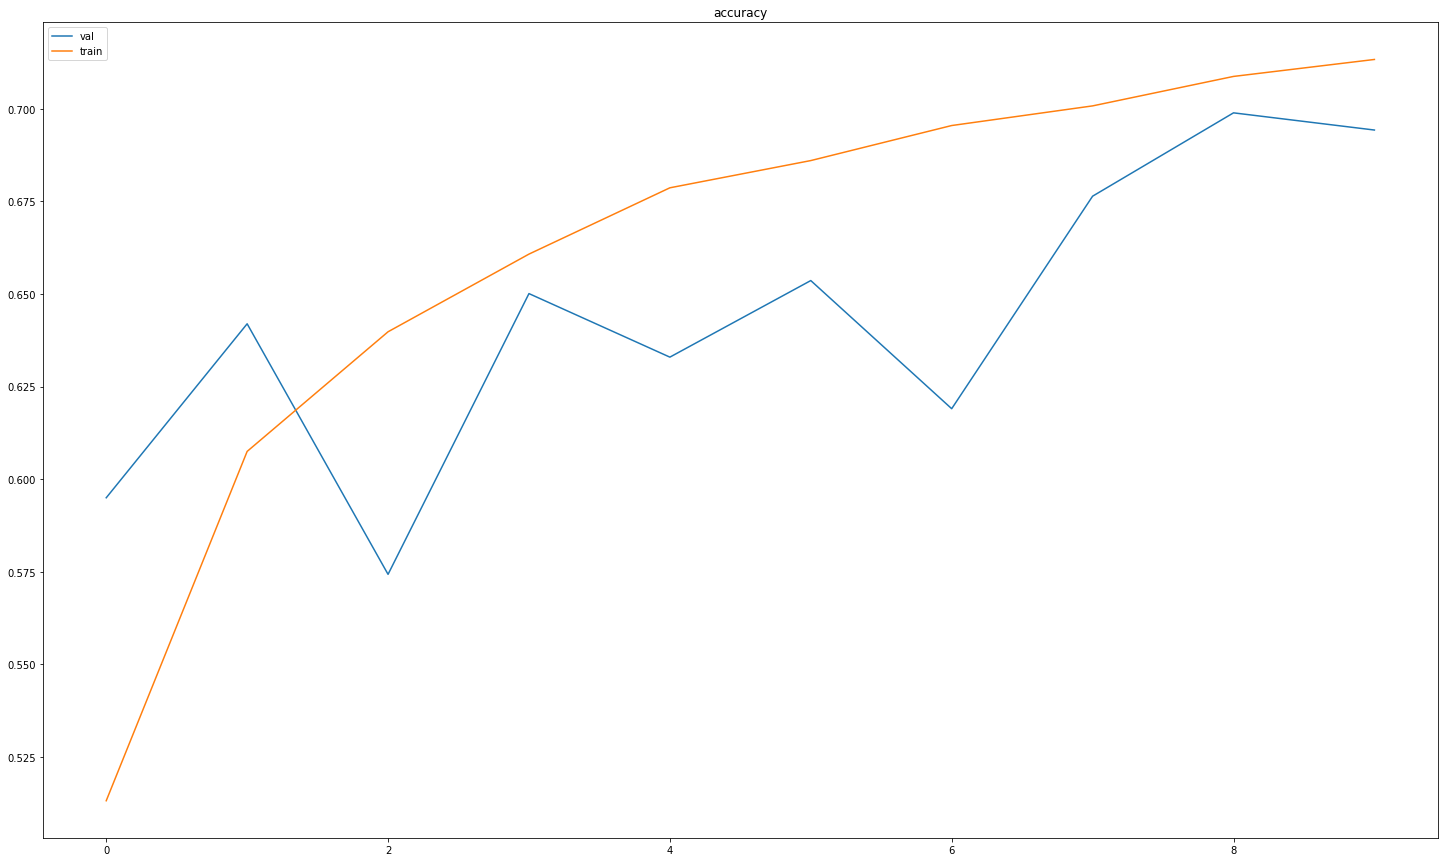

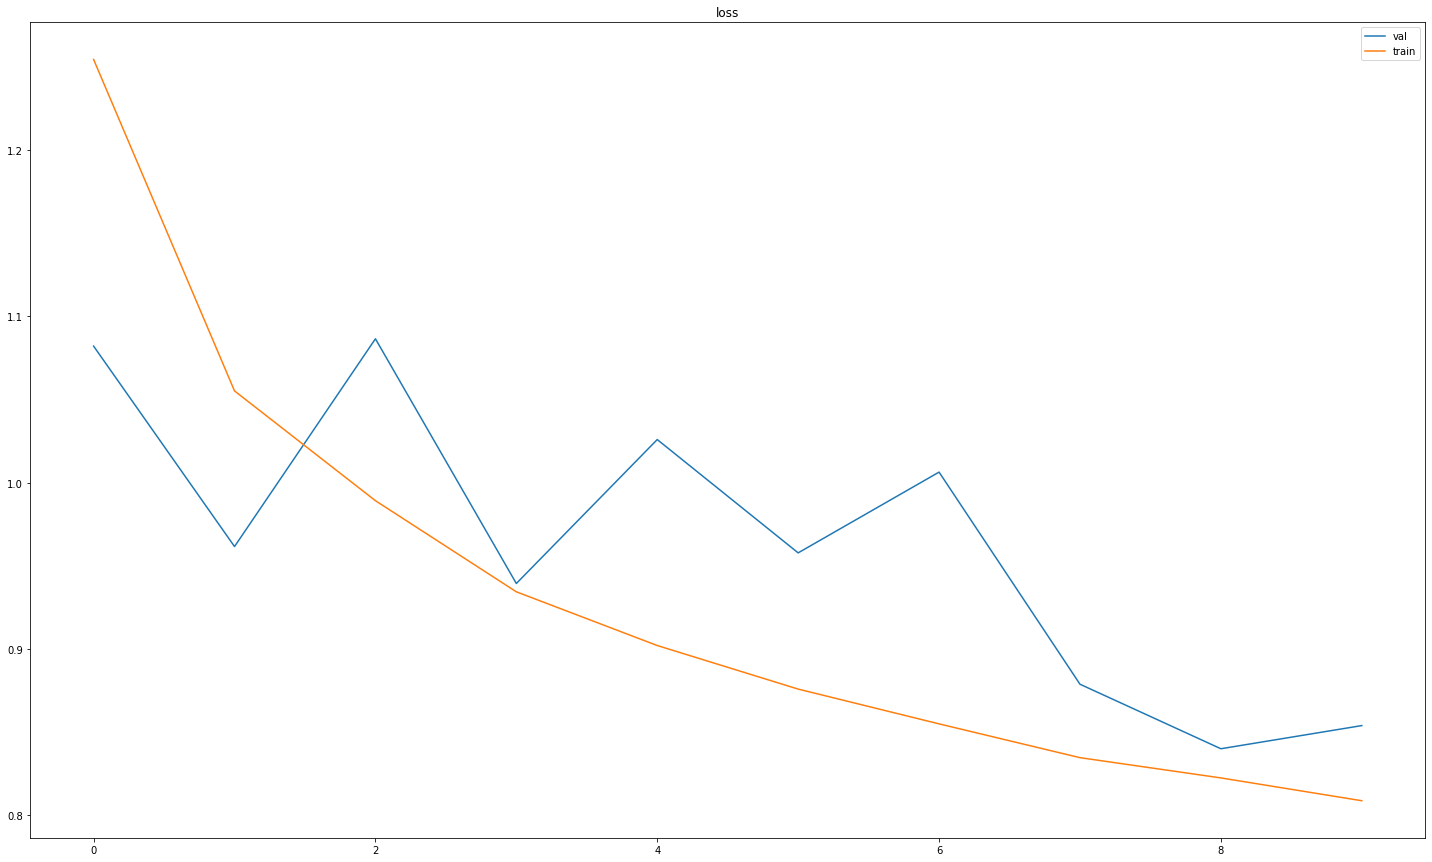

              precision    recall  f1-score   support

       White       0.37      0.03      0.05       553
       Black       0.64      0.50      0.57      1165
       Asian       0.62      0.78      0.69      1064
      Indian       0.87      0.67      0.76      1334
      Others       0.69      0.87      0.77      2995

    accuracy                           0.69      7111
   macro avg       0.64      0.57      0.57      7111
weighted avg       0.68      0.69      0.67      7111

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 1024)              10241024  
________________________________

In [132]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.compat.v1.train.MomentumOptimizer(
                                                                learning_rate=0.01,
                                                                momentum=0.5
                                                            ), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=10)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

Epoch 1/10
519/519 [==============================] - 52s 99ms/step - loss: 1.2876 - accuracy: 0.5040 - val_loss: 1.1834 - val_accuracy: 0.5562
Epoch 2/10
519/519 [==============================] - 51s 99ms/step - loss: 1.1788 - accuracy: 0.5507 - val_loss: 1.1676 - val_accuracy: 0.5659
Epoch 3/10
519/519 [==============================] - 52s 99ms/step - loss: 1.1351 - accuracy: 0.5734 - val_loss: 1.1396 - val_accuracy: 0.5833
Epoch 4/10
519/519 [==============================] - 52s 99ms/step - loss: 1.0420 - accuracy: 0.6138 - val_loss: 1.0877 - val_accuracy: 0.6019
Epoch 5/10
519/519 [==============================] - 51s 99ms/step - loss: 0.9929 - accuracy: 0.6443 - val_loss: 0.9494 - val_accuracy: 0.6595
Epoch 6/10
519/519 [==============================] - 51s 98ms/step - loss: 0.9631 - accuracy: 0.6555 - val_loss: 0.8977 - val_accuracy: 0.6819
Epoch 7/10
519/519 [==============================] - 51s 98ms/step - loss: 0.9474 - accuracy: 0.6628 - val_loss: 1.0024 - val_accuracy:

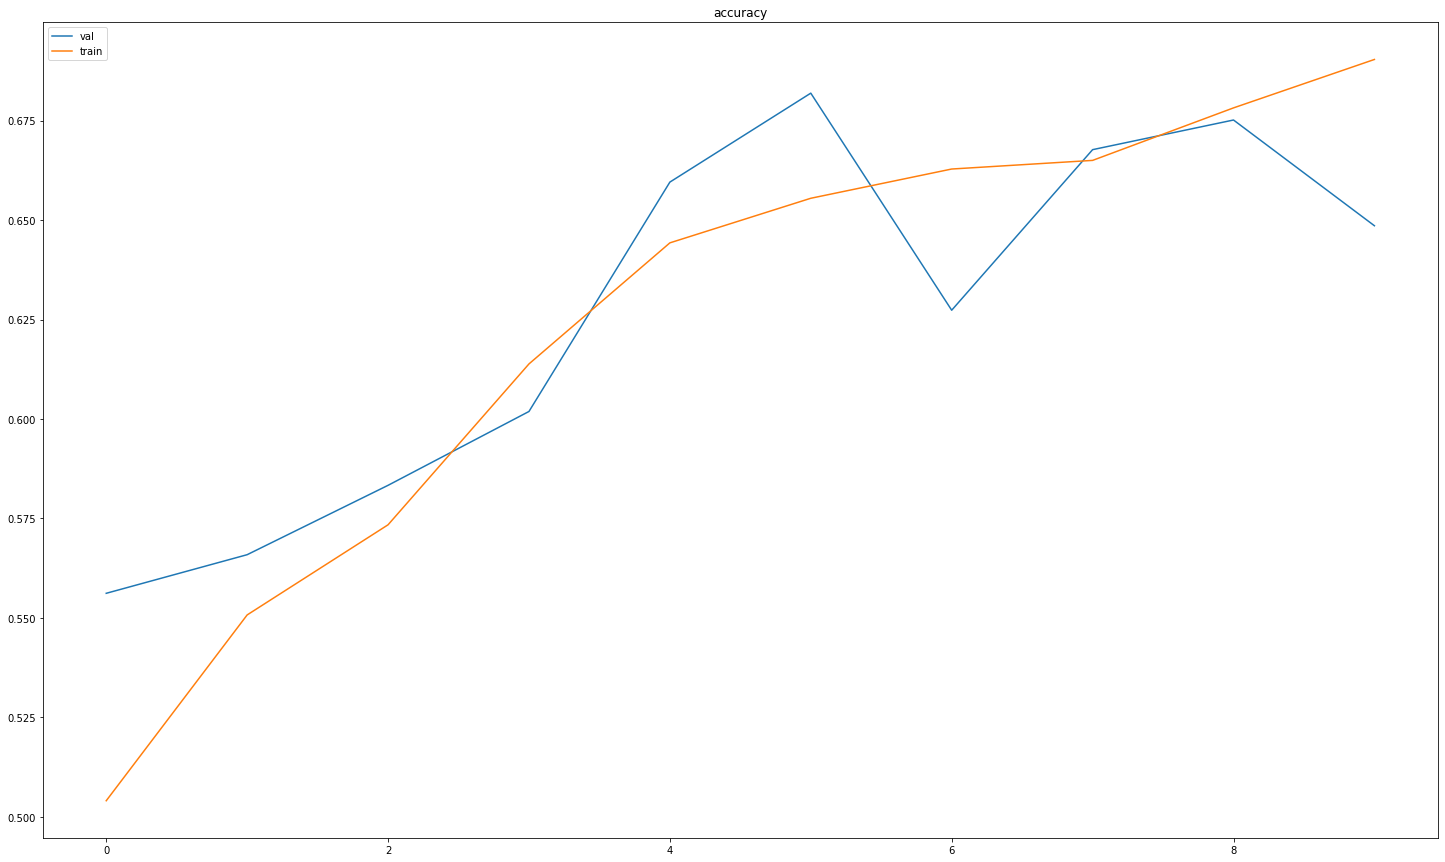

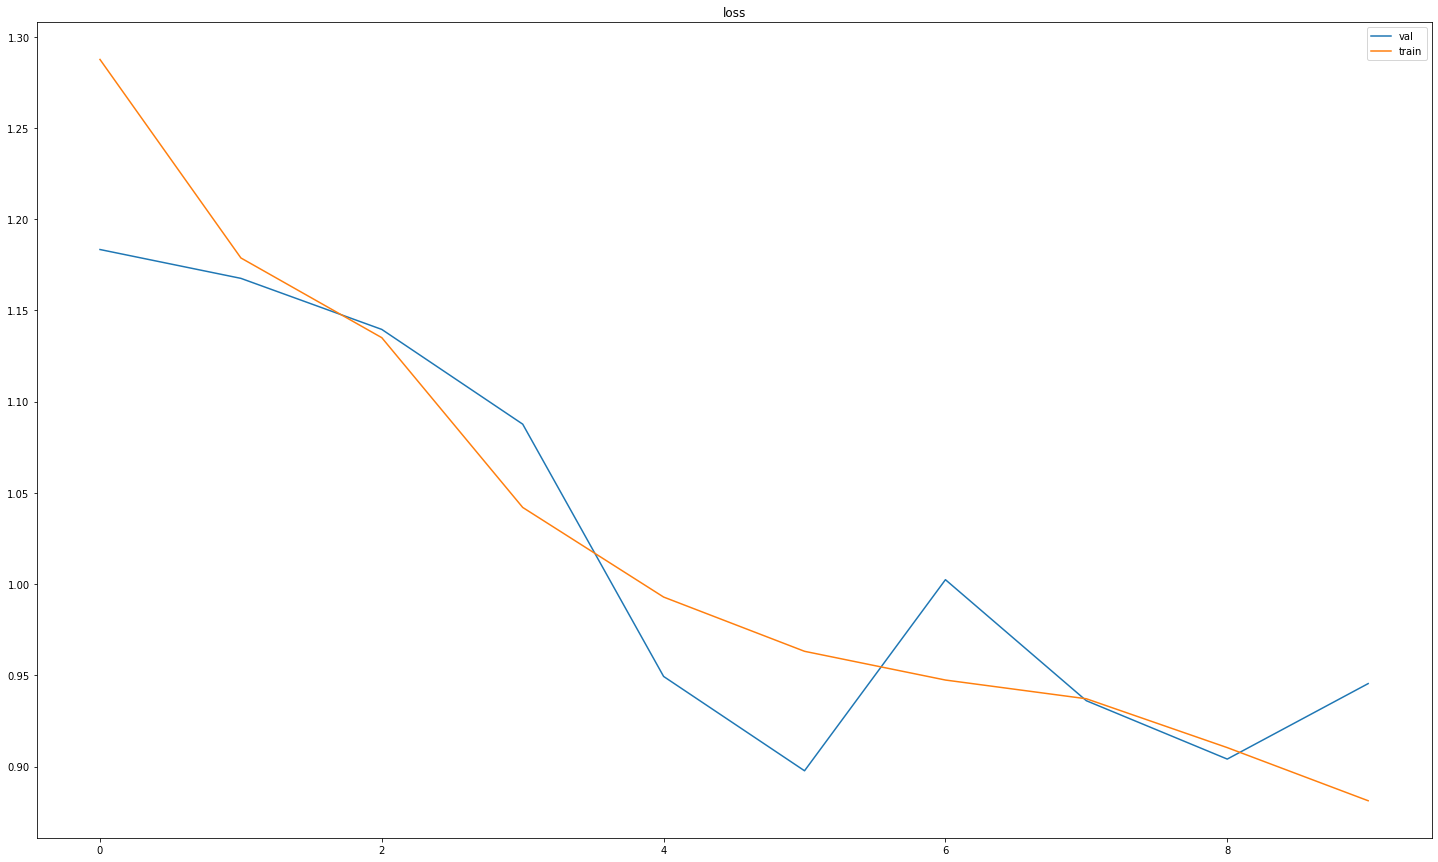

              precision    recall  f1-score   support

       White       0.17      0.00      0.01       553
       Black       0.61      0.39      0.48      1165
       Asian       0.86      0.47      0.60      1064
      Indian       0.87      0.64      0.73      1334
      Others       0.59      0.94      0.72      2995

    accuracy                           0.65      7111
   macro avg       0.62      0.49      0.51      7111
weighted avg       0.65      0.65      0.61      7111

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              10241024  
________________________________

In [133]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.compat.v1.train.MomentumOptimizer(
                                                                learning_rate=0.01,
                                                                momentum=0.9
                                                            ), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=10)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

As we see above and the part I explained earlier, increasing the momentum wont always result in better performance

### Using Adam

Epoch 1/10
519/519 [==============================] - 67s 128ms/step - loss: 1.3904 - accuracy: 0.5122 - val_loss: 1.0650 - val_accuracy: 0.6220
Epoch 2/10
519/519 [==============================] - 62s 119ms/step - loss: 1.0644 - accuracy: 0.6117 - val_loss: 1.0088 - val_accuracy: 0.6294
Epoch 3/10
519/519 [==============================] - 62s 119ms/step - loss: 0.9709 - accuracy: 0.6495 - val_loss: 0.9863 - val_accuracy: 0.6394
Epoch 4/10
519/519 [==============================] - 64s 123ms/step - loss: 0.9291 - accuracy: 0.6691 - val_loss: 1.0123 - val_accuracy: 0.6358
Epoch 5/10
519/519 [==============================] - 62s 119ms/step - loss: 0.9051 - accuracy: 0.6796 - val_loss: 0.9125 - val_accuracy: 0.6694
Epoch 6/10
519/519 [==============================] - 62s 120ms/step - loss: 0.8931 - accuracy: 0.6855 - val_loss: 0.9063 - val_accuracy: 0.6695
Epoch 7/10
519/519 [==============================] - 63s 121ms/step - loss: 0.8606 - accuracy: 0.6993 - val_loss: 0.9454 - val_ac

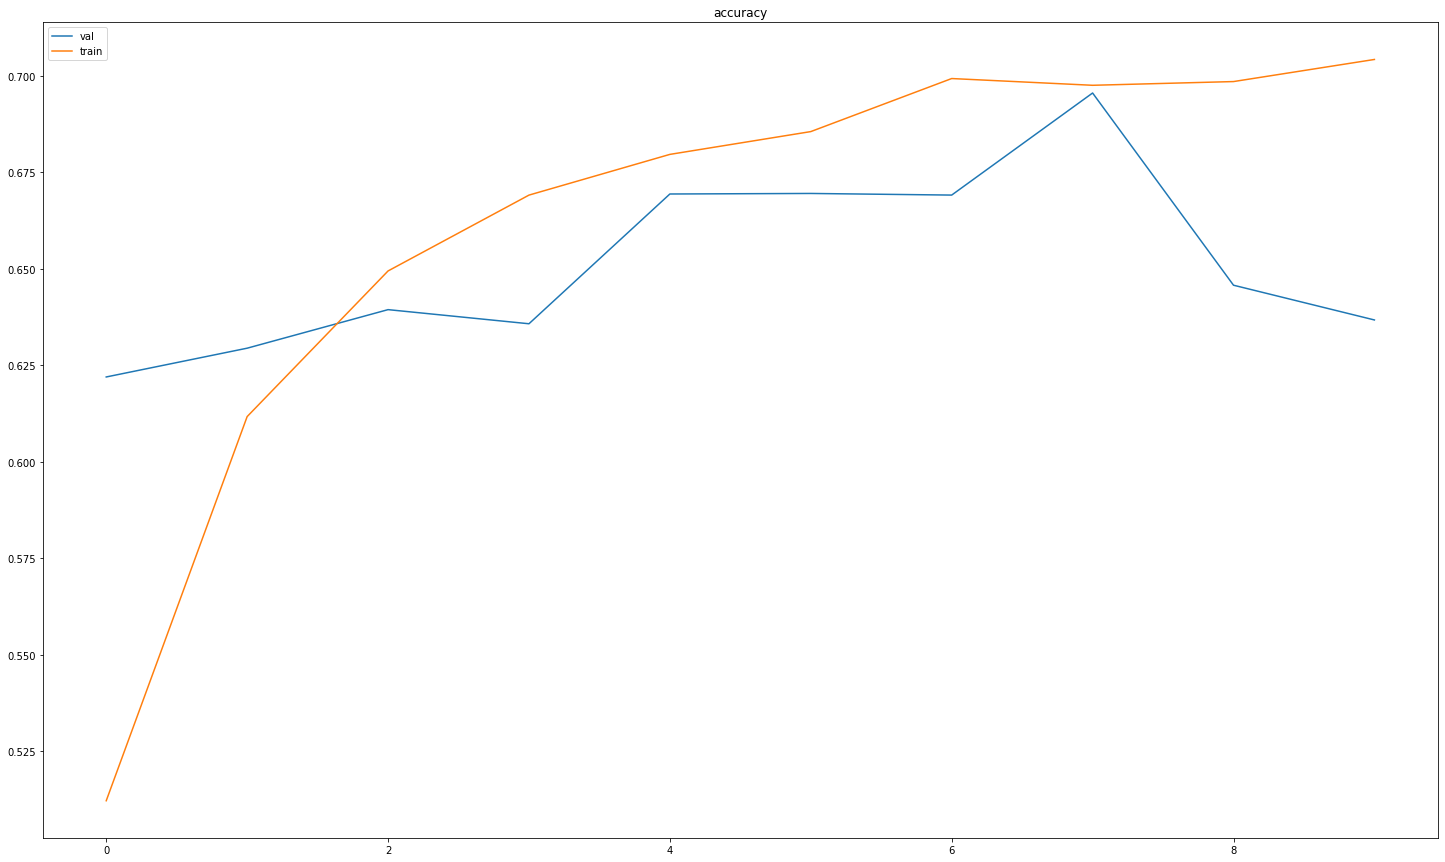

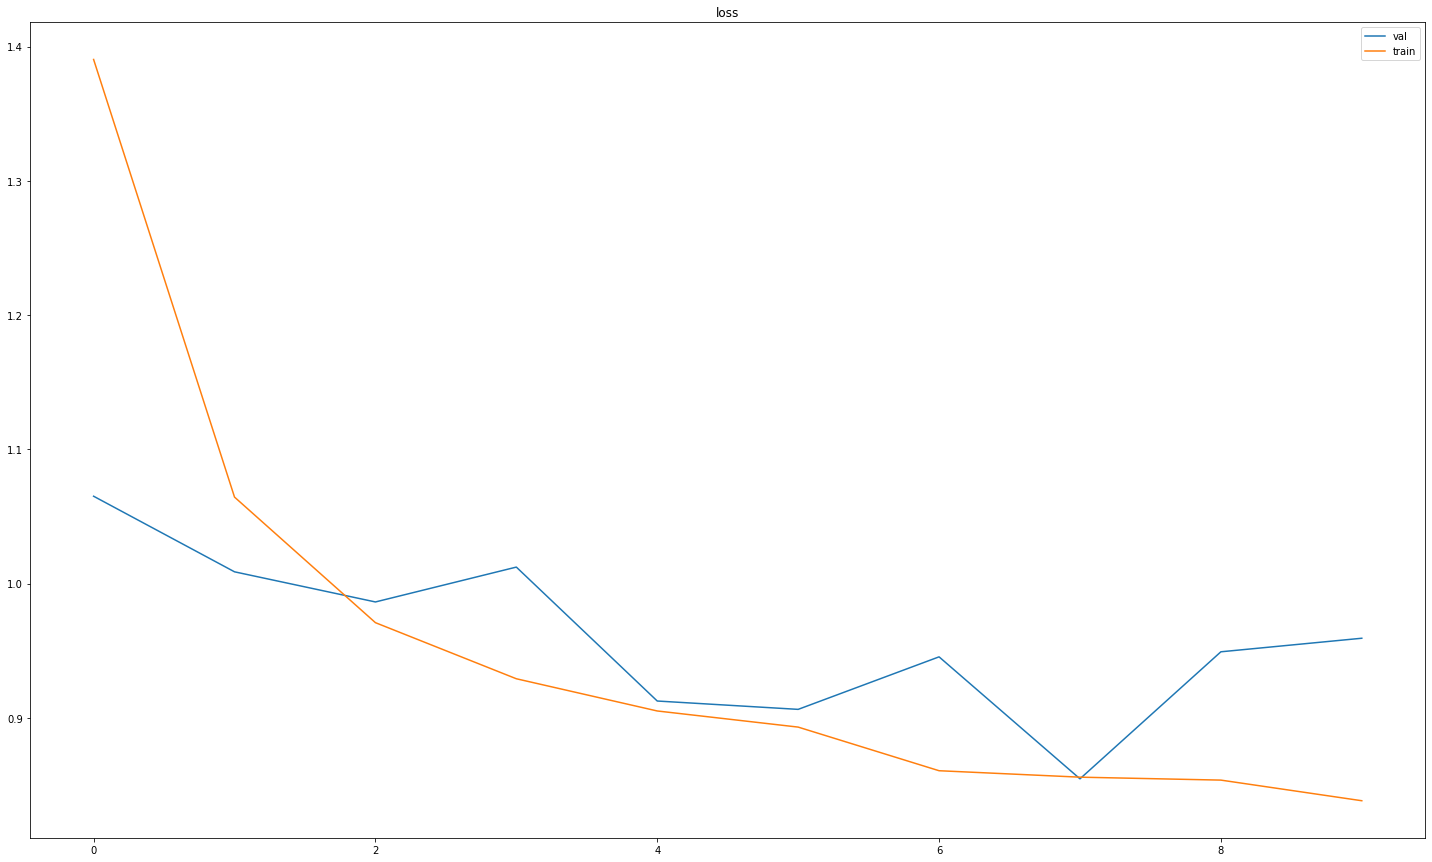

              precision    recall  f1-score   support

       White       0.33      0.01      0.02       553
       Black       0.36      0.88      0.52      1165
       Asian       0.77      0.65      0.70      1064
      Indian       0.85      0.66      0.75      1334
      Others       0.82      0.64      0.72      2995

    accuracy                           0.64      7111
   macro avg       0.63      0.57      0.54      7111
weighted avg       0.71      0.64      0.63      7111

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              10241024  
__________________________________

In [18]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=10)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

#### Answer
As we see above, Adam seems to over fit the data meaning the test data isen't getting as good accuracy as the training data. I would prefere using sgd.

## Part2 effect of epochs

Epoch 1/20
519/519 [==============================] - 65s 125ms/step - loss: 1.4325 - accuracy: 0.5135 - val_loss: 1.1514 - val_accuracy: 0.5650
Epoch 2/20
519/519 [==============================] - 65s 126ms/step - loss: 1.0392 - accuracy: 0.6209 - val_loss: 1.0506 - val_accuracy: 0.5950
Epoch 3/20
519/519 [==============================] - 64s 124ms/step - loss: 0.9612 - accuracy: 0.6546 - val_loss: 0.9448 - val_accuracy: 0.6574
Epoch 4/20
519/519 [==============================] - 64s 124ms/step - loss: 0.9663 - accuracy: 0.6537 - val_loss: 1.0387 - val_accuracy: 0.6348
Epoch 5/20
519/519 [==============================] - 65s 126ms/step - loss: 0.9268 - accuracy: 0.6722 - val_loss: 0.8781 - val_accuracy: 0.6891
Epoch 6/20
519/519 [==============================] - 65s 126ms/step - loss: 0.8809 - accuracy: 0.6893 - val_loss: 0.8560 - val_accuracy: 0.6950
Epoch 7/20
519/519 [==============================] - 65s 125ms/step - loss: 0.8847 - accuracy: 0.6862 - val_loss: 0.8771 - val_ac

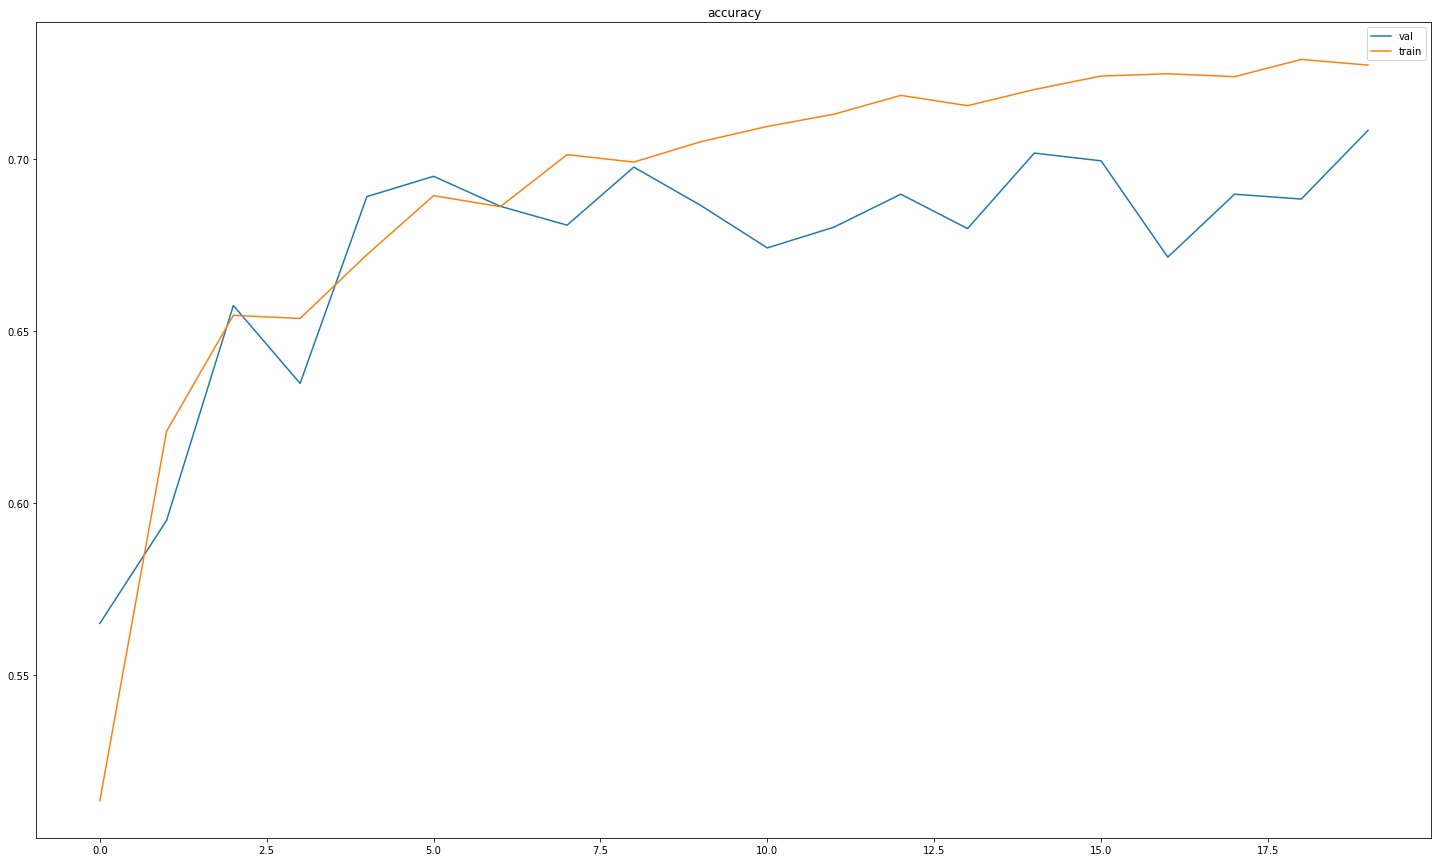

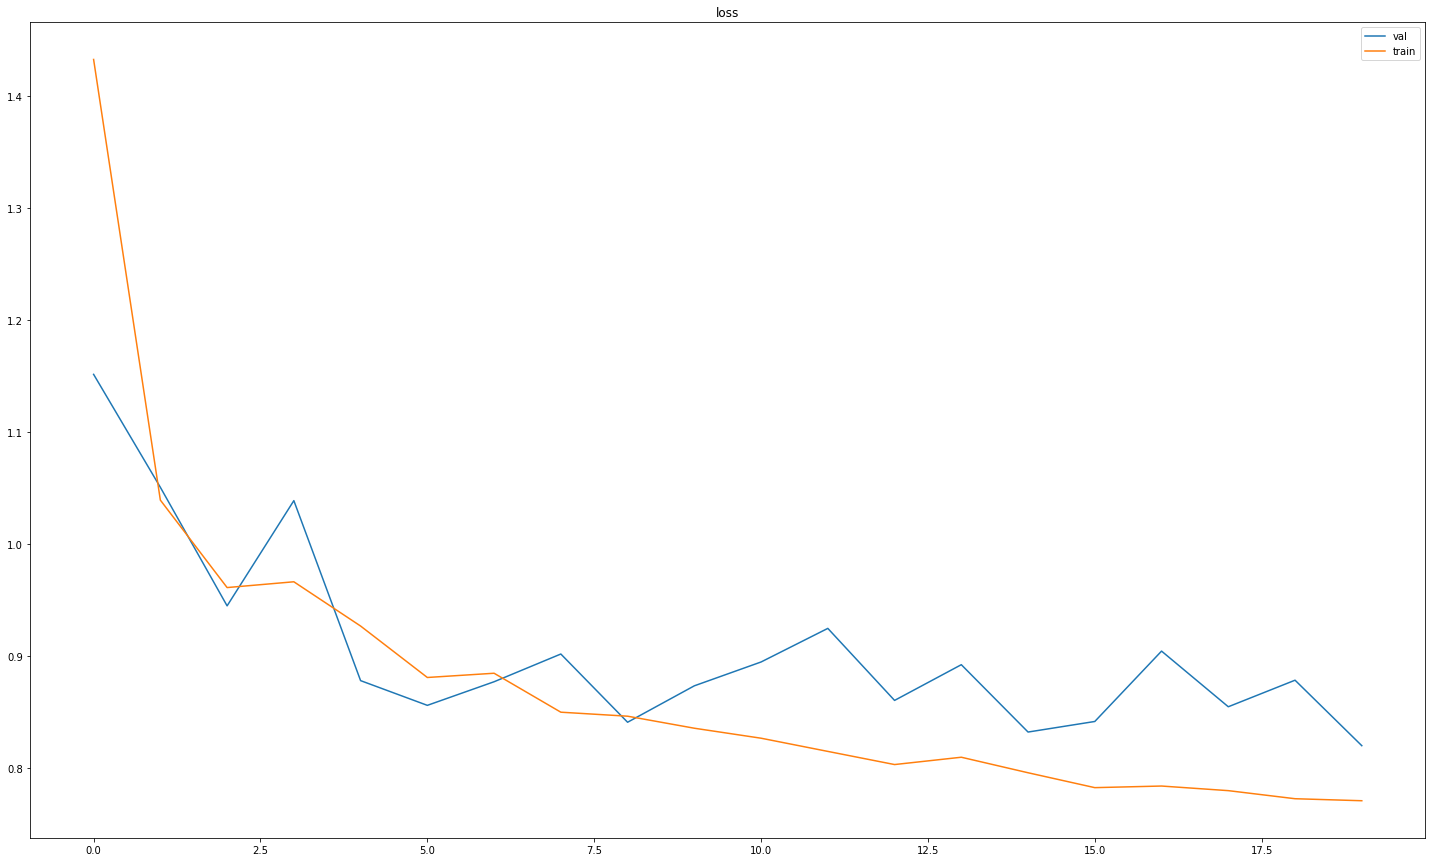

              precision    recall  f1-score   support

       White       0.35      0.06      0.10       553
       Black       0.53      0.73      0.61      1165
       Asian       0.73      0.71      0.72      1064
      Indian       0.76      0.79      0.77      1334
      Others       0.79      0.78      0.78      2995

    accuracy                           0.71      7111
   macro avg       0.63      0.61      0.60      7111
weighted avg       0.70      0.71      0.69      7111

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              10241024  
________________________________

In [19]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=20)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

#### Question
As these models are all itterative we see that more wee itterate though the data the more the model gets trained to fit the data. This comes at a cost of risking overfitting. as we see after a certain number of epochs the validation accuracy wont increase but we see the train accuracy is getting higher, at this point we say the data is overfitting and a good way to avoid it is monitoring epochs and stoping when we feel overfitting is happening.

# Part 3: loss function

Epoch 1/20
519/519 [==============================] - 56s 107ms/step - loss: 0.3226 - accuracy: 0.1921 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 2/20
519/519 [==============================] - 55s 105ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 3/20
519/519 [==============================] - 55s 105ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 4/20
519/519 [==============================] - 55s 106ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 5/20
519/519 [==============================] - 55s 105ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 6/20
519/519 [==============================] - 55s 105ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_accuracy: 0.1876
Epoch 7/20
519/519 [==============================] - 55s 106ms/step - loss: 0.3231 - accuracy: 0.1924 - val_loss: 0.3250 - val_ac

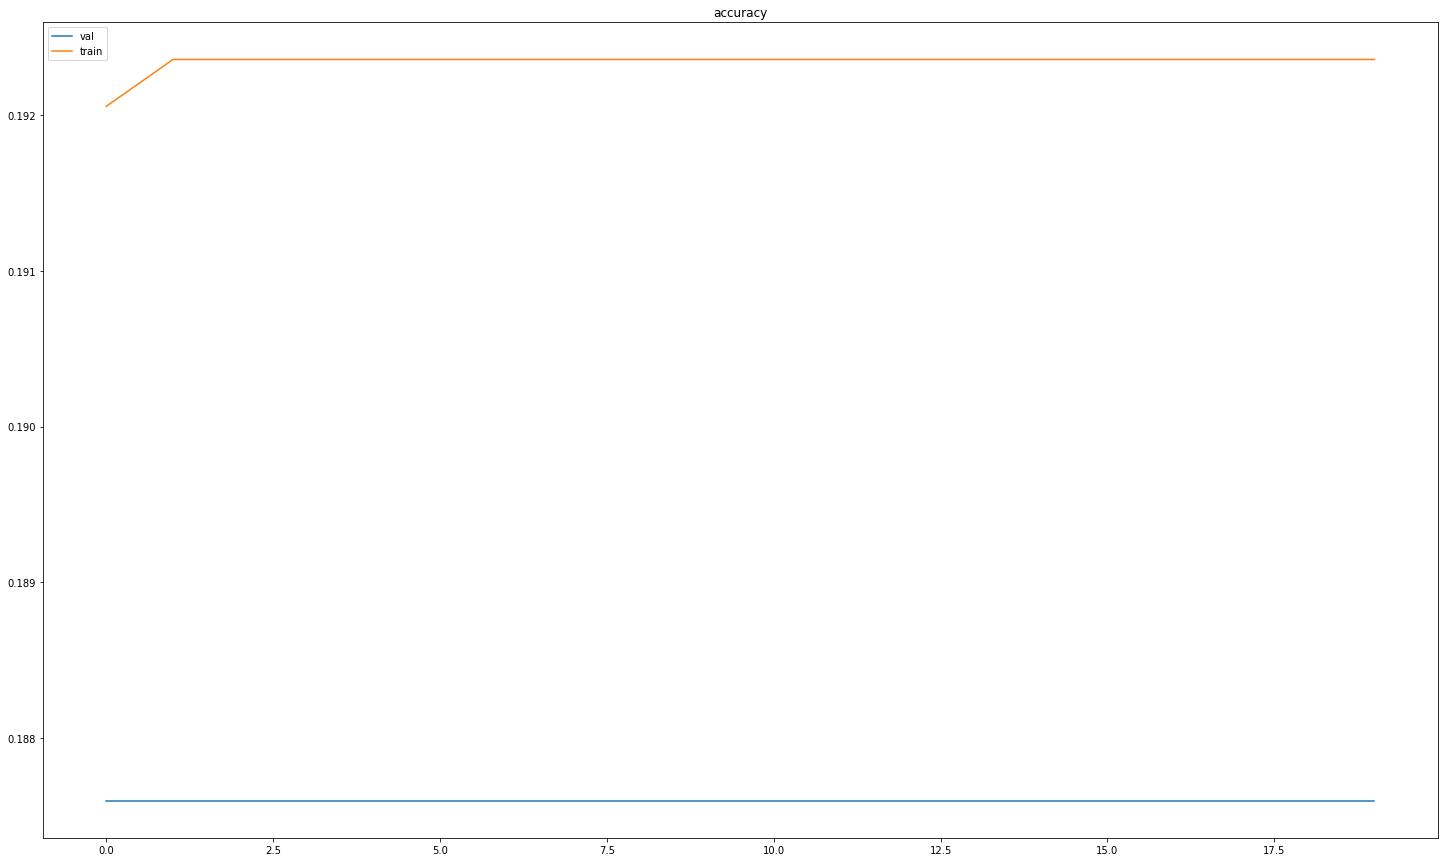

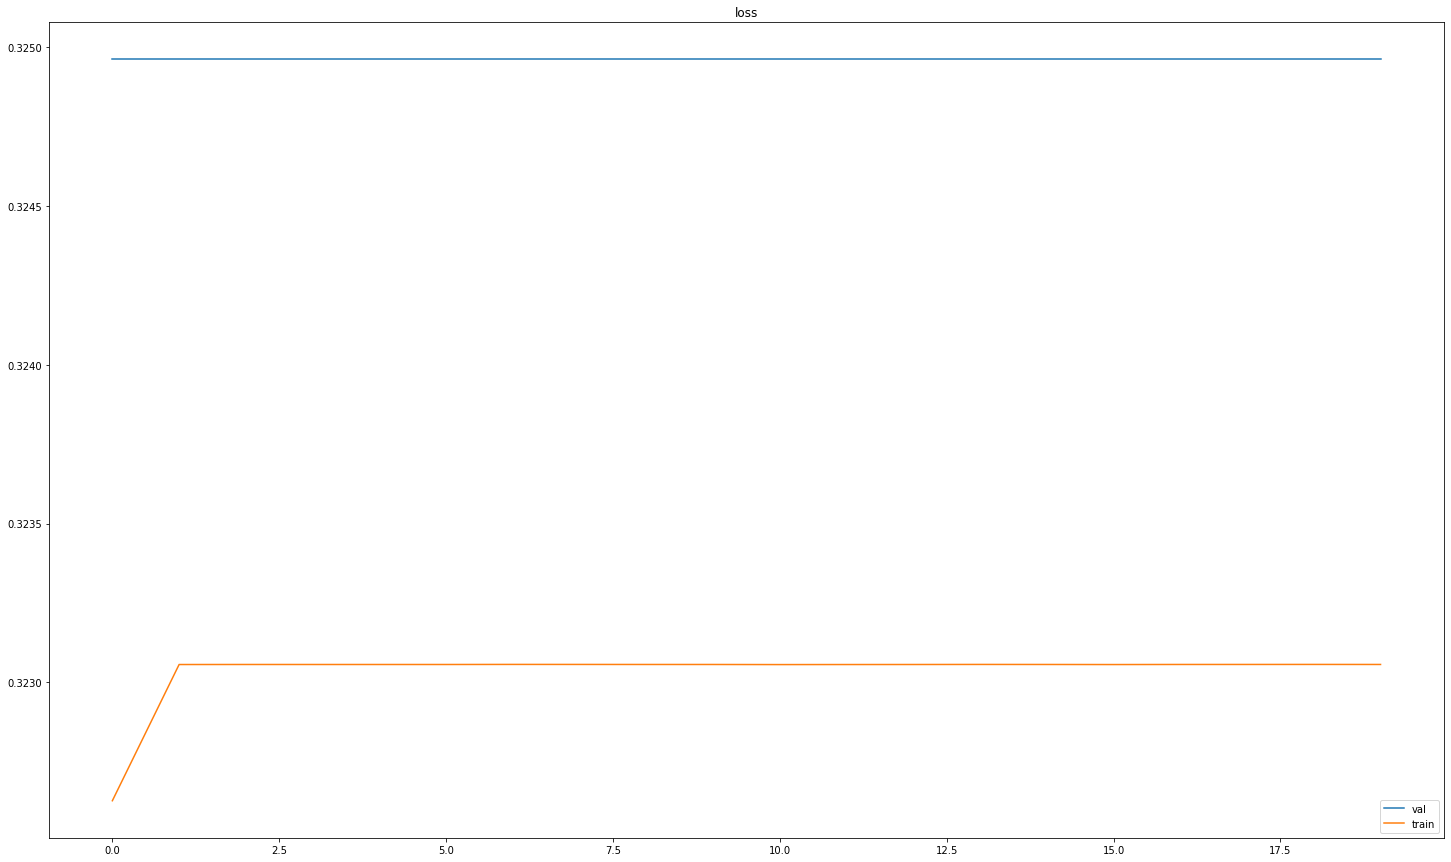

              precision    recall  f1-score   support

       White       0.00      0.00      0.00       553
       Black       0.00      0.00      0.00      1165
       Asian       0.00      0.00      0.00      1064
      Indian       0.19      1.00      0.32      1334
      Others       0.00      0.00      0.00      2995

    accuracy                           0.19      7111
   macro avg       0.04      0.20      0.06      7111
weighted avg       0.04      0.19      0.06      7111

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              10241024  
__________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanSquaredError() , metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=20)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

### Why not use this
As we see above the this classification model does not respond well to this loss function. This loss function is mostly used for regression and not for classification, because it doesn't give a good score for predicting correctly and only fucuses on bad parts of every prediction.<br>
This would be good for predicting age

# Part 4: Regularization

> ### L2 regularization



Epoch 1/20
519/519 [==============================] - 56s 107ms/step - loss: 1.4874 - accuracy: 0.4908 - val_loss: 1.1611 - val_accuracy: 0.5403
Epoch 2/20
519/519 [==============================] - 55s 106ms/step - loss: 1.1589 - accuracy: 0.5531 - val_loss: 1.3271 - val_accuracy: 0.4366
Epoch 3/20
519/519 [==============================] - 55s 106ms/step - loss: 1.1263 - accuracy: 0.5792 - val_loss: 1.0827 - val_accuracy: 0.5982
Epoch 4/20
519/519 [==============================] - 55s 106ms/step - loss: 1.0915 - accuracy: 0.5982 - val_loss: 1.0522 - val_accuracy: 0.6172
Epoch 5/20
519/519 [==============================] - 55s 106ms/step - loss: 1.0686 - accuracy: 0.6073 - val_loss: 1.1845 - val_accuracy: 0.5659
Epoch 6/20
519/519 [==============================] - 55s 106ms/step - loss: 1.0705 - accuracy: 0.6038 - val_loss: 1.0466 - val_accuracy: 0.6247
Epoch 7/20
519/519 [==============================] - 55s 106ms/step - loss: 1.0470 - accuracy: 0.6191 - val_loss: 1.1632 - val_ac

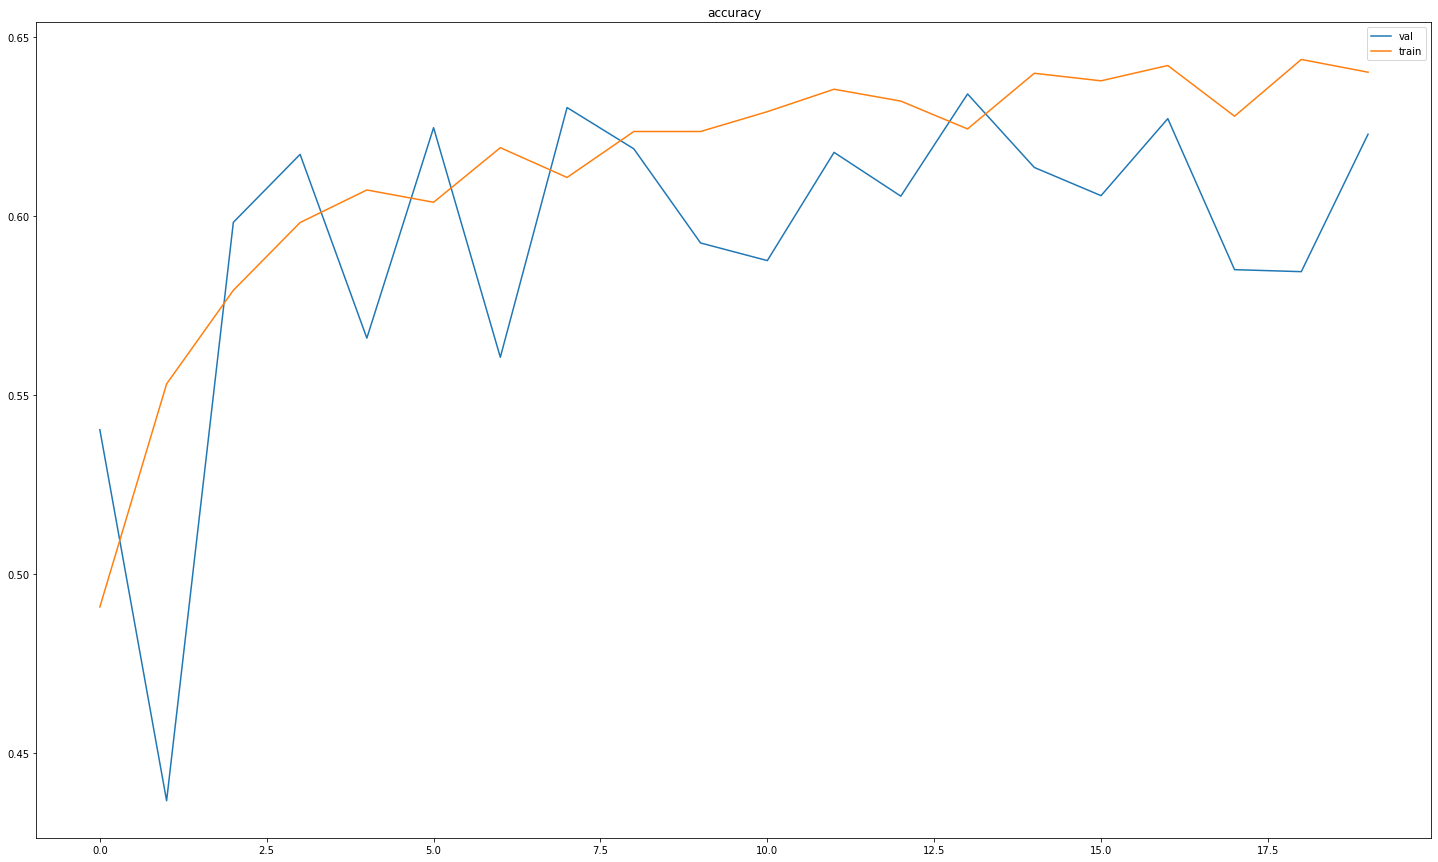

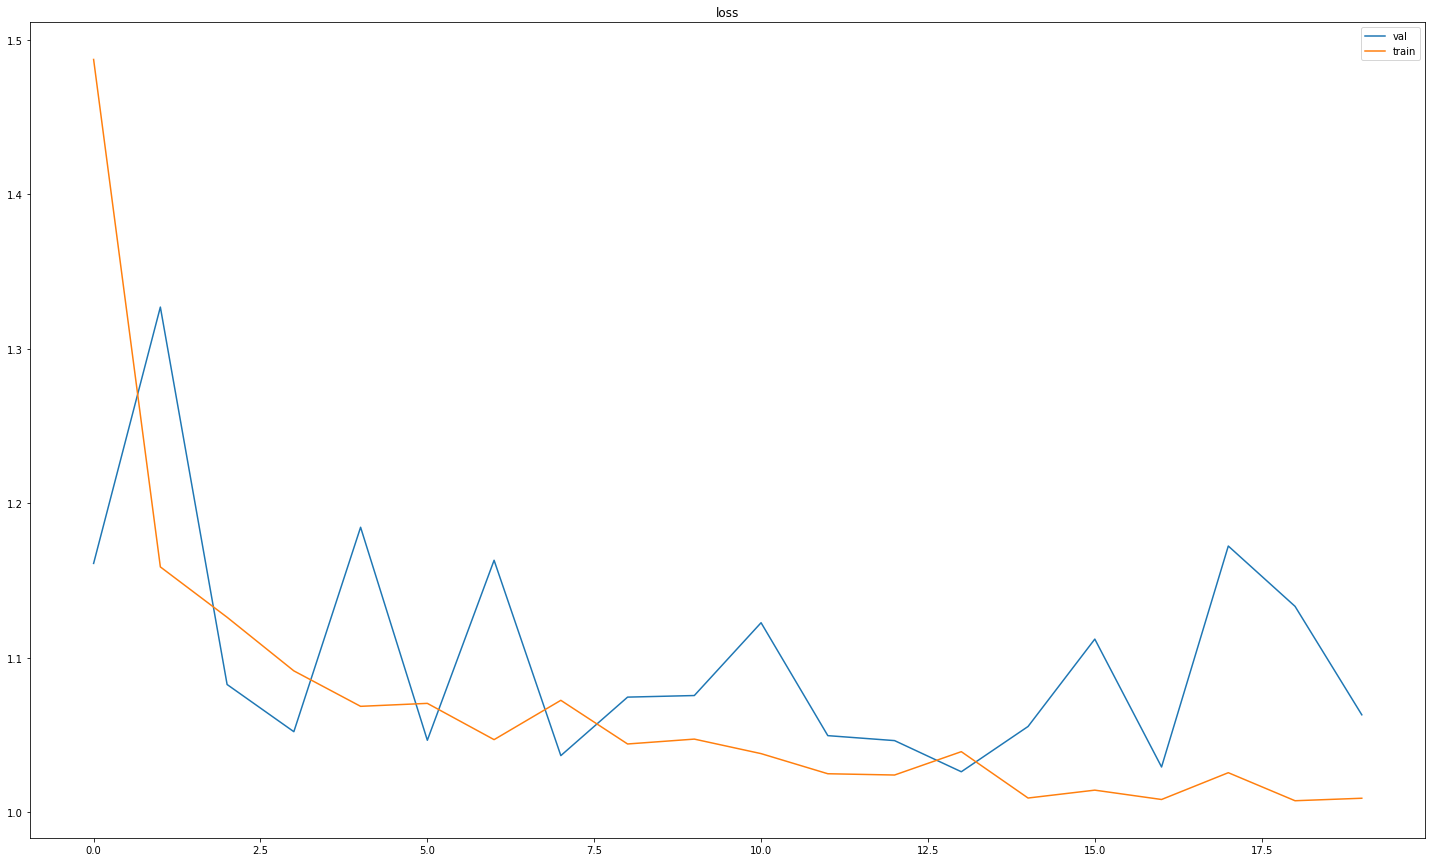

              precision    recall  f1-score   support

       White       0.00      0.00      0.00       553
       Black       0.51      0.47      0.49      1165
       Asian       0.50      0.72      0.59      1064
      Indian       0.78      0.56      0.65      1334
      Others       0.66      0.79      0.72      2995

    accuracy                           0.62      7111
   macro avg       0.49      0.51      0.49      7111
weighted avg       0.58      0.62      0.60      7111

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              10241024  
________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dense(512, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dense(256, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=20)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

### Result
As we see above this technique helps us to prevent overfitting by trying to regulize nodes in a way that gives penalties to nodes not being balanced which helps us to have more balanced and active nodes and no dead nodes.

> ## Dropout

Epoch 1/20
519/519 [==============================] - 55s 106ms/step - loss: 1.4668 - accuracy: 0.4570 - val_loss: 1.4636 - val_accuracy: 0.4036
Epoch 2/20
519/519 [==============================] - 55s 105ms/step - loss: 1.2995 - accuracy: 0.4962 - val_loss: 1.3837 - val_accuracy: 0.4731
Epoch 3/20
519/519 [==============================] - 55s 105ms/step - loss: 1.2885 - accuracy: 0.5054 - val_loss: 1.2629 - val_accuracy: 0.5175
Epoch 4/20
519/519 [==============================] - 55s 106ms/step - loss: 1.2754 - accuracy: 0.5050 - val_loss: 1.2059 - val_accuracy: 0.5455
Epoch 5/20
519/519 [==============================] - 55s 106ms/step - loss: 1.2709 - accuracy: 0.5096 - val_loss: 1.2060 - val_accuracy: 0.5463
Epoch 6/20
519/519 [==============================] - 55s 105ms/step - loss: 1.2702 - accuracy: 0.5078 - val_loss: 1.2195 - val_accuracy: 0.5469
Epoch 7/20
519/519 [==============================] - 55s 105ms/step - loss: 1.2680 - accuracy: 0.5095 - val_loss: 1.3171 - val_ac

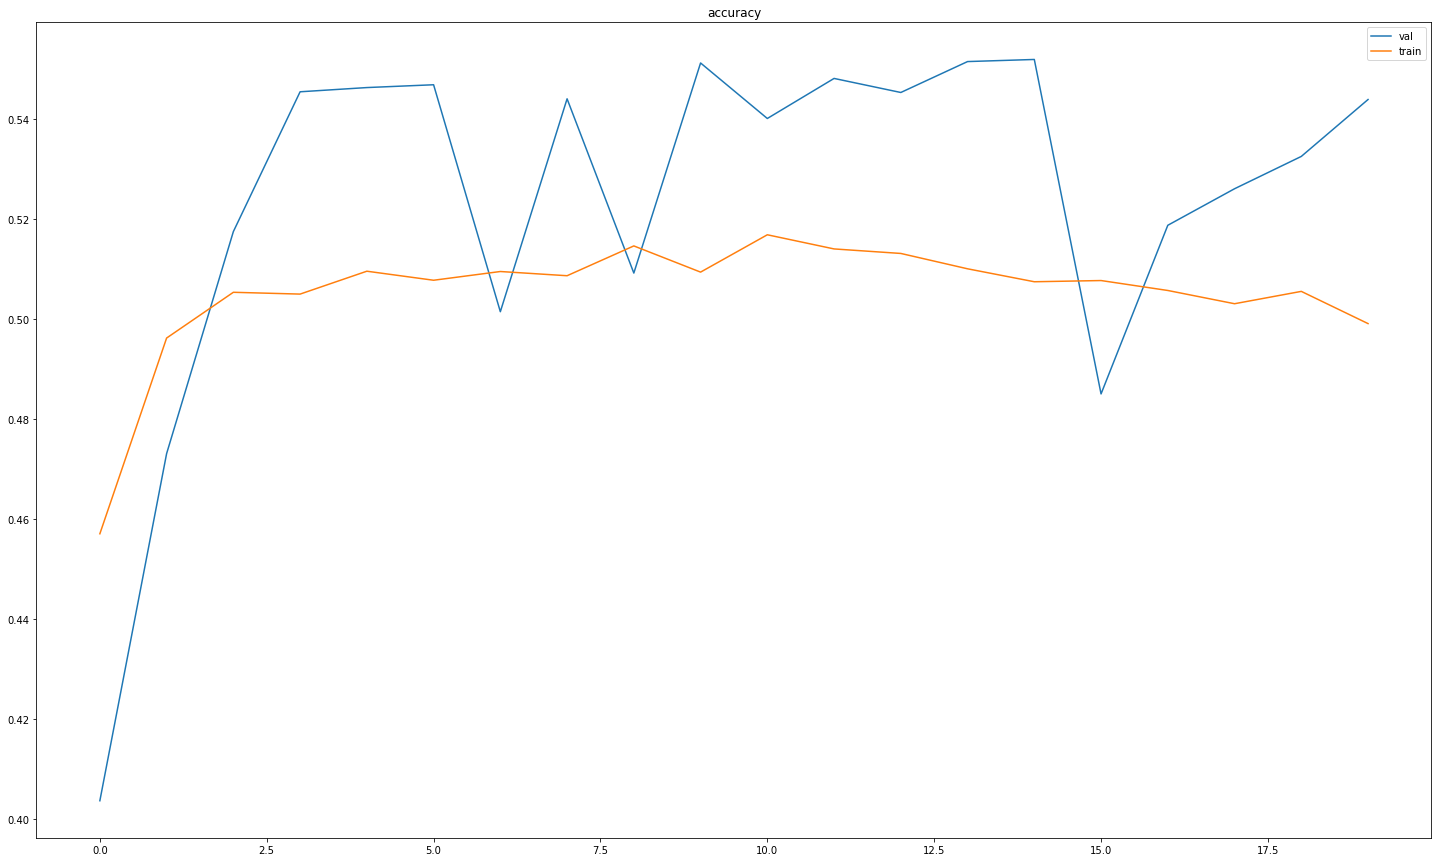

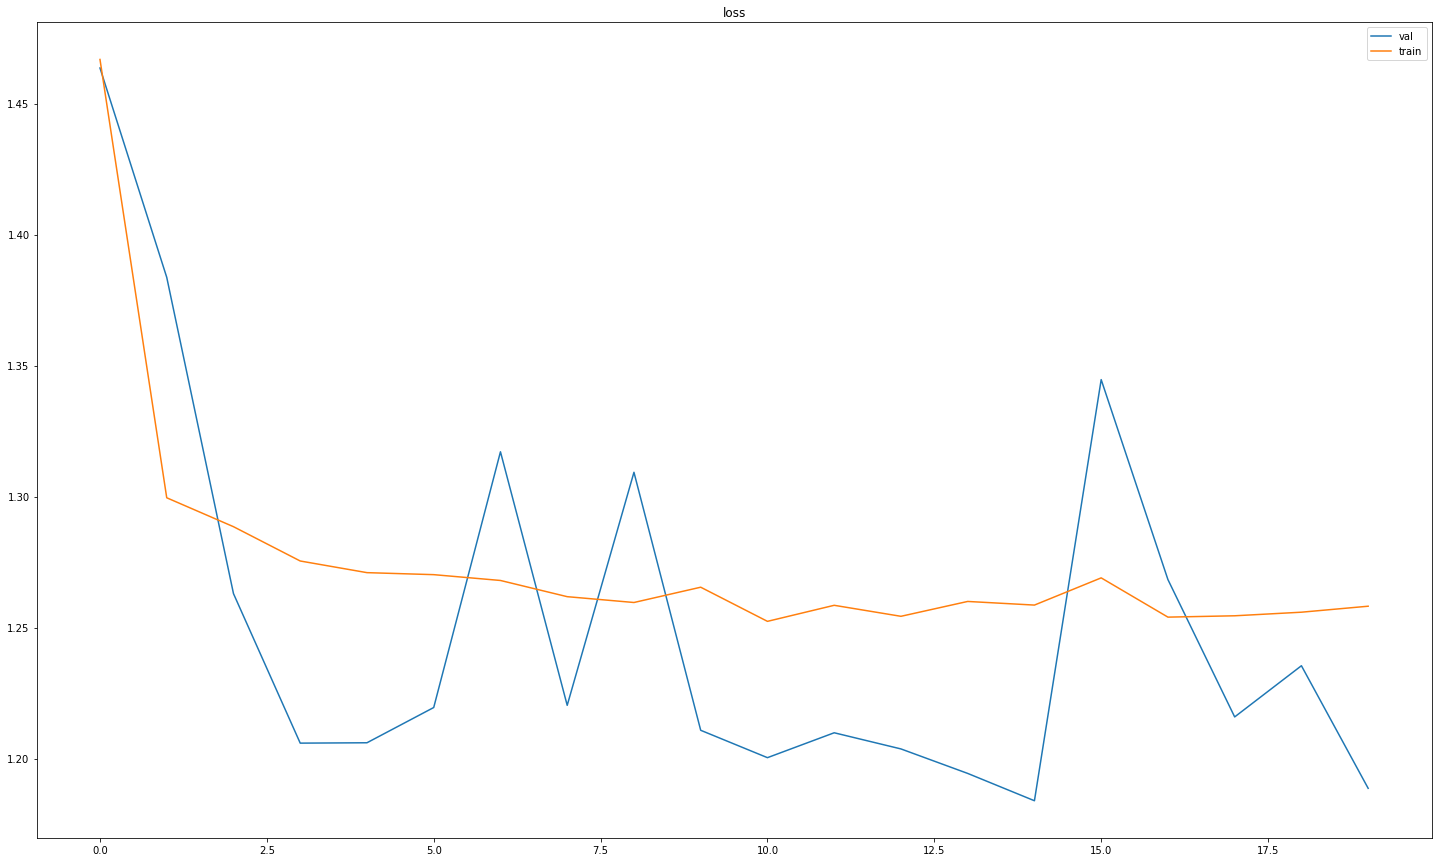

              precision    recall  f1-score   support

       White       0.00      0.00      0.00       553
       Black       0.38      0.15      0.21      1165
       Asian       1.00      0.00      0.01      1064
      Indian       0.64      0.67      0.65      1334
      Others       0.53      0.94      0.68      2995

    accuracy                           0.54      7111
   macro avg       0.51      0.35      0.31      7111
weighted avg       0.56      0.54      0.44      7111

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              10241024  
________________________________

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dropout(.1)(output)
output = layers.Dense(512, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dropout(.1)(output)
output = layers.Dense(256, activation="relu", activity_regularizer=tf.keras.regularizers.l2(1e-4))(output)
output = layers.Dropout(.1)(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=20)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

### Result
As we see above having such a big dropout ratio led to underfitting and loosing accuracy

# The best model is the model below

Epoch 1/20
519/519 [==============================] - 44s 84ms/step - loss: 1.2876 - accuracy: 0.4940 - val_loss: 1.1305 - val_accuracy: 0.5701
Epoch 2/20
519/519 [==============================] - 44s 84ms/step - loss: 1.1263 - accuracy: 0.5758 - val_loss: 1.0618 - val_accuracy: 0.6043
Epoch 3/20
519/519 [==============================] - 43s 84ms/step - loss: 1.0442 - accuracy: 0.6123 - val_loss: 0.9856 - val_accuracy: 0.6538
Epoch 4/20
519/519 [==============================] - 43s 84ms/step - loss: 0.9840 - accuracy: 0.6407 - val_loss: 0.9231 - val_accuracy: 0.6591
Epoch 5/20
519/519 [==============================] - 44s 84ms/step - loss: 0.9437 - accuracy: 0.6589 - val_loss: 0.9079 - val_accuracy: 0.6652
Epoch 6/20
519/519 [==============================] - 44s 85ms/step - loss: 0.9182 - accuracy: 0.6695 - val_loss: 0.8833 - val_accuracy: 0.6782
Epoch 7/20
519/519 [==============================] - 44s 84ms/step - loss: 0.8902 - accuracy: 0.6783 - val_loss: 1.1984 - val_accuracy:

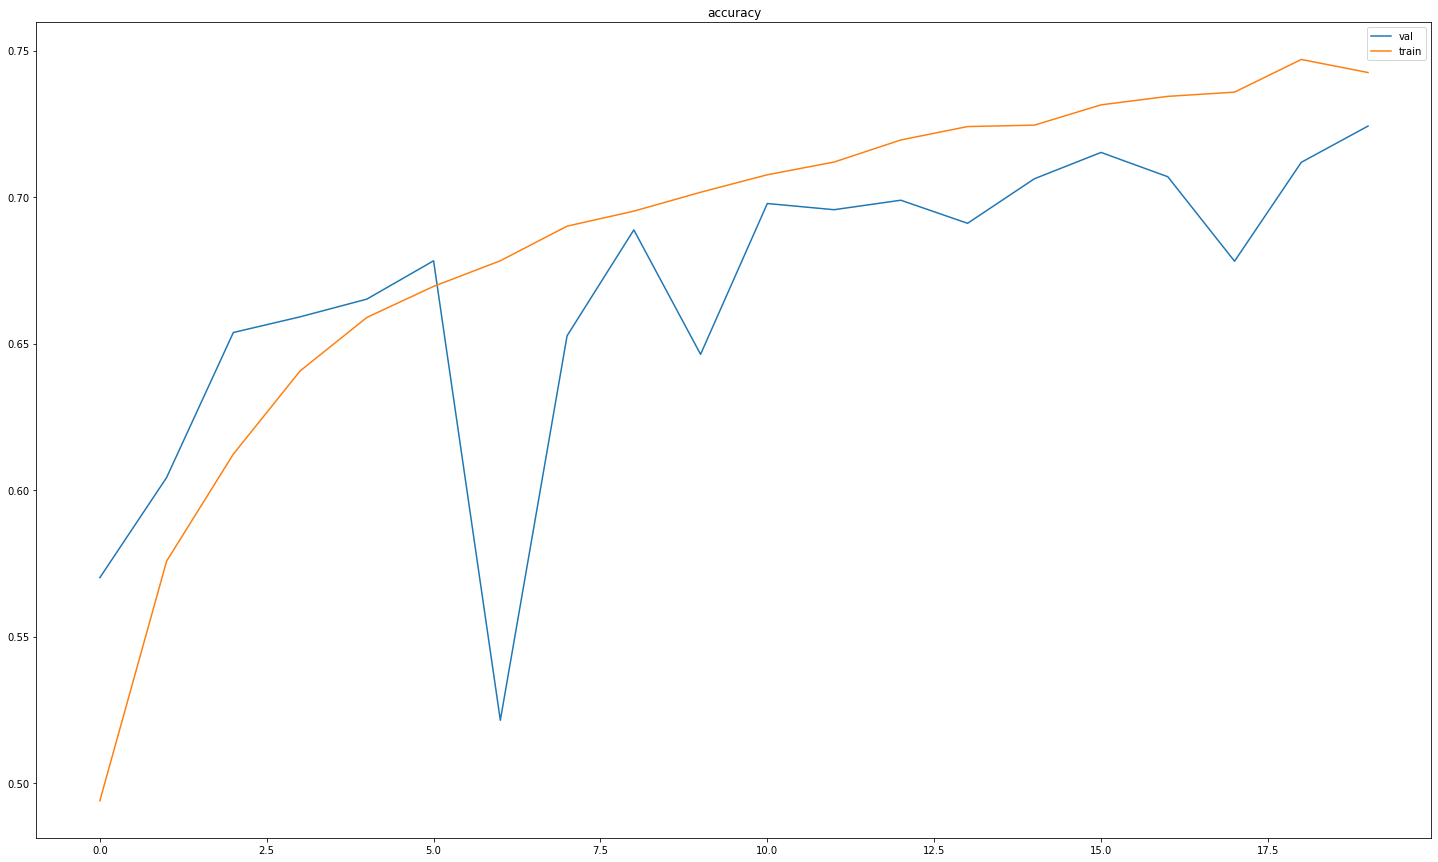

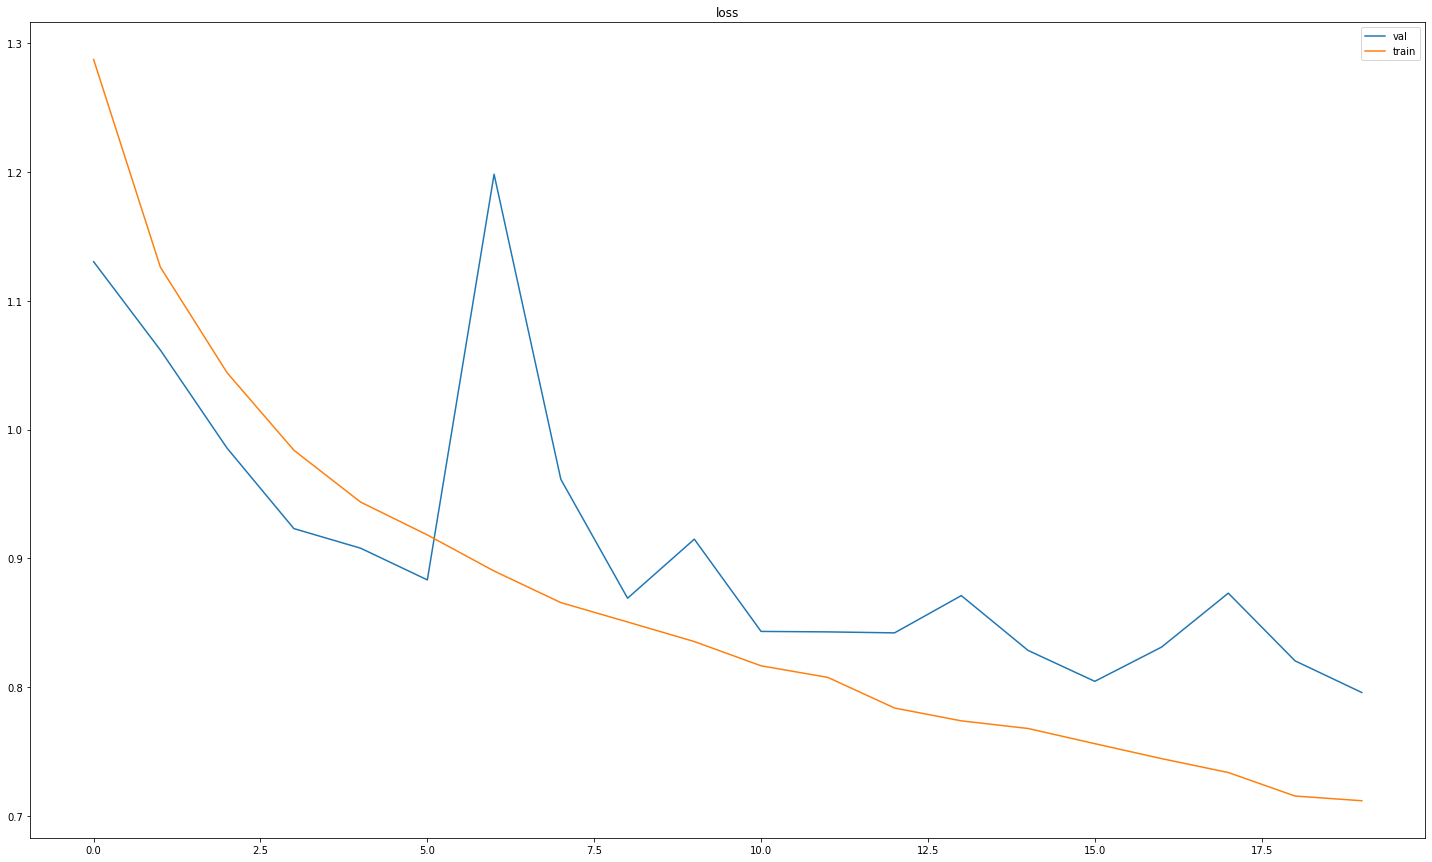

              precision    recall  f1-score   support

       White       0.72      0.87      0.79      2995
       Black       0.82      0.77      0.80      1334
       Asian       0.71      0.74      0.72      1064
      Indian       0.66      0.61      0.63      1165
      Others       0.43      0.03      0.05       553

    accuracy                           0.72      7111
   macro avg       0.67      0.60      0.60      7111
weighted avg       0.70      0.72      0.70      7111

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              10241024  
________________________________

In [56]:
input = layers.Input(shape = (100, 100, 1))

output = layers.Flatten()(input)
output = layers.Dense(1024, activation="relu")(output)
output = layers.Dense(512, activation="relu")(output)
output = layers.Dense(256, activation="relu")(output)
output = layers.Dense(5, activation="softmax")(output)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=optimizers.SGD(learning_rate=.01), loss="categorical_crossentropy", metrics=["accuracy"])

log = model.fit(X_train, validation_data=X_test, epochs=20)

plt.figure(figsize = (25,15))
plt.title('accuracy')
plt.plot(log.epoch, log.history["val_accuracy"], label='val')
plt.plot(log.epoch, log.history["accuracy"], label='train')
plt.legend()
plt.show()

plt.figure(figsize = (25,15))
plt.title('loss')
plt.plot(log.epoch, log.history["val_loss"], label="val")
plt.plot(log.epoch, log.history["loss"], label = "train")
plt.legend()
plt.show()

y_true = X_test.labels
y_test = model.predict(X_test)
y_test = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_test, target_names=list(ClassLabels.values())))

model.summary()

### finding 10 correct and 10 incorrect images
>> 10 correct

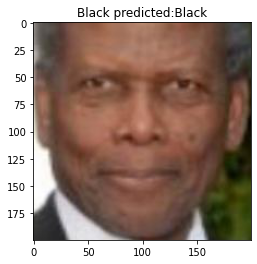

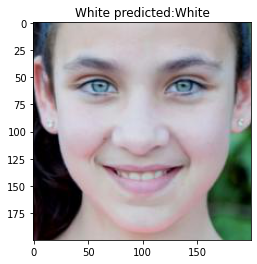

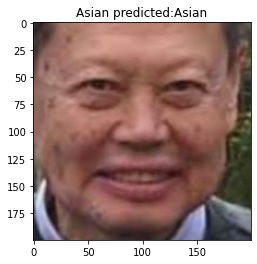

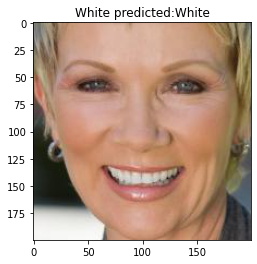

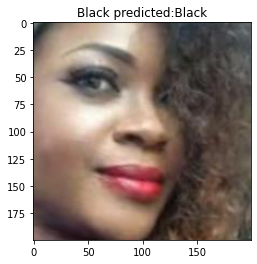

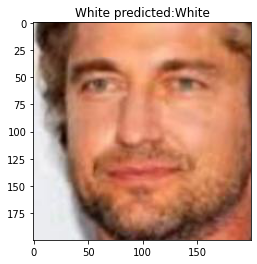

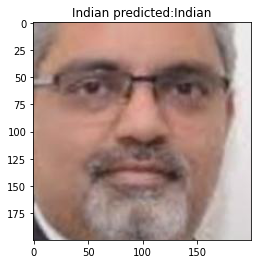

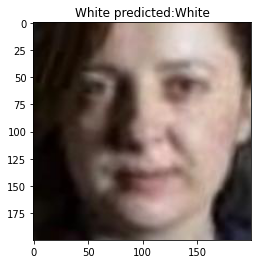

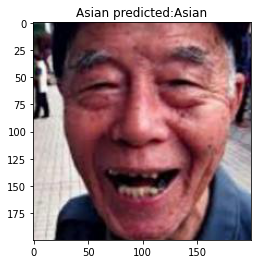

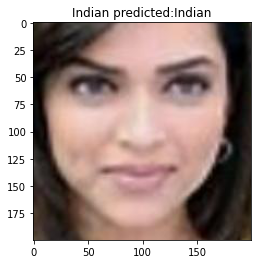

In [57]:
from scipy import misc
import imageio
j = 0
for i in range(10):
  while(y_true[j] != y_test[j]):
    j += 1
  img = imageio.imread(X_test.filepaths[j])
  plt.title(ClassLabels[y_true[j]] + " predicted:" + ClassLabels[y_test[j]])
  plt.imshow(img)
  plt.show()
  j += 1

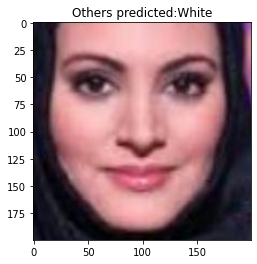

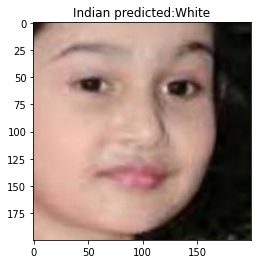

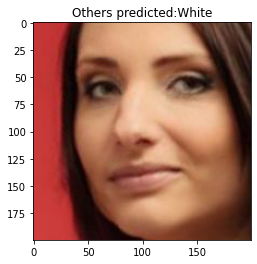

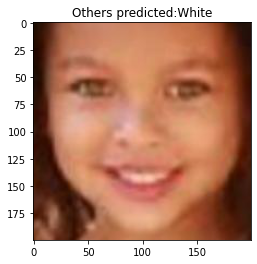

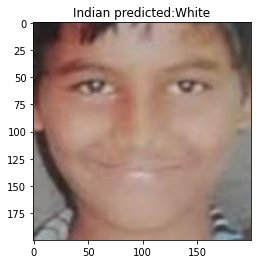

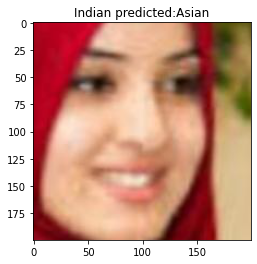

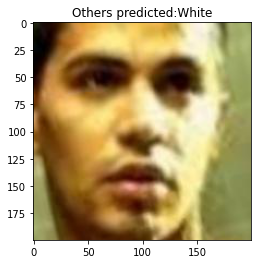

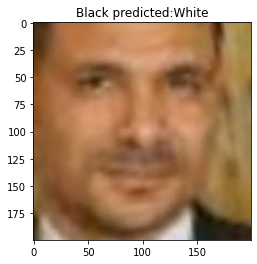

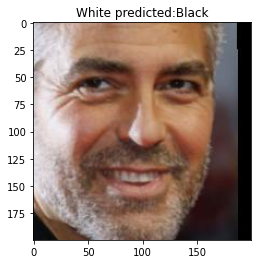

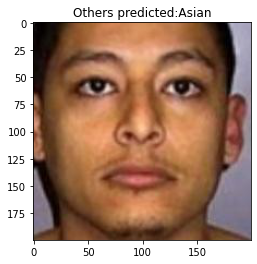

In [58]:
from scipy import misc
import imageio
j = 0
for i in range(10):
  while(y_true[j] == y_test[j]):
    j += 1
  img = imageio.imread(X_test.filepaths[j])
  plt.title(ClassLabels[y_true[j]] + " predicted:" + ClassLabels[y_test[j]])
  plt.imshow(img)
  plt.show()
  j += 1

# P4 : Variational encoder

In [71]:
latent_dim = 2

input = layers.Input(shape = (100, 100, 1))
h0 = layers.Flatten()(input)
h1 = layers.Dense(1024, activation='relu')(h0)
h2 = layers.Dense(512, activation='relu')(h1)
h3 = layers.Dense(256, activation='relu')(h2)

z = layers.Dense(latent_dim)(h3)

encoder = models.Model(input, z, name='encoder')

output = layers.Dense(5, activation="softmax")(z)

model = models.Model(inputs = input, outputs = output)

model.compile(optimizer=optimizers.SGD(learning_rate=.01), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

log = model.fit(X_train, validation_data=X_test, epochs=10)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 100, 100, 1)]     0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_47 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
dense_48 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_49 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 514       
_________________________________________________________________
dense_51 (Dense)             (None, 5)                 15  

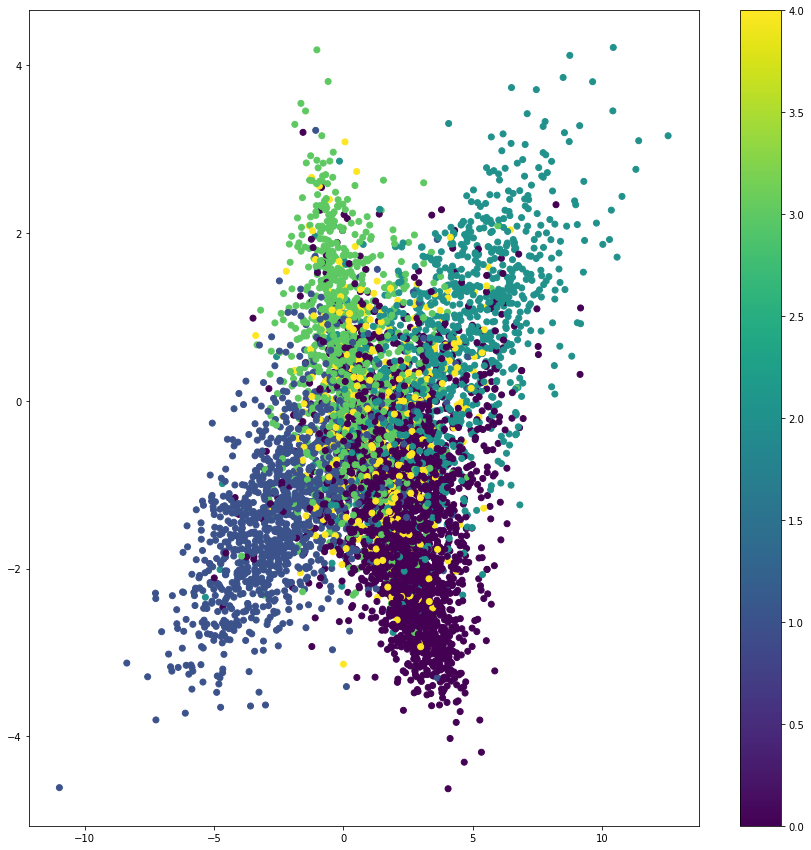

In [72]:
y_true = X_test.labels
X_test_encoded = encoder.predict(X_test)
plt.figure(figsize=(15, 15))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=y_true)
plt.colorbar()
plt.show()

### Result
As we see above and having ClassLabels = {0:"White", 1:"Black", 2:"Asian", 3:"Indian", 4:"Others"}
we see that the models seperates black and white quite well from each other and other classes. Indian is closer to black and asian is closer to white.
the other classes mostly get classified as indian and asian.<br>
other class is the most dificult to classify, and this is the reason why f1 is so low for others class.